In [1]:
import sys;
sys.path.append(r'.') 
from heisenberg_model import HeisenbergModel; 


<ipython-input-1-7a39aa5580a9>:3: NatureDeprecationWarning: The qiskit_nature.operators package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.operators package.
  from heisenberg_model import HeisenbergModel;


In [2]:
import numpy as np

from time import time

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [3]:
#import retworkx as rx
import rustworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
from heisenberg_model import HeisenbergModel

In [17]:
# Kagome unit cell
num_sites = 12
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 0, t),
    (0, 6, t),
    (1, 6, t),
    (1, 7, t),
    (2, 7, t),
    (2, 8, t),
    (3, 8, t),
    (3, 9, t),
    (4, 9, t),
    (4, 10, t),
    (5, 10, t),
    (5, 11, t),
    (0, 11, t),
]

singles_list = [
    #(0, 1, t),
    (1, 2, t),#
    #(2, 3, t),
    #(3, 4, t),
    #(4, 5, t), 
    (5, 0, t),#
    #(0, 6, t),
    #(1, 6, t),
    #(1, 7, t), 
    #(2, 7, t),
    #(2, 8, t),
    #(3, 8, t),
    (3, 9, t),#
    #(4, 9, t),
    (4, 10, t),#
    #(5, 10, t),
    #(5, 11, t),
    #(0, 11, t),
]

timereversal_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 0, t),
    (6, 0, t),
    (1, 6, t),
    (7, 1, t),
    (2, 7, t),
    (8, 2, t),
    (3, 8, t),
    (9, 3, t),
    (4, 9, t),
    (10,4, t),
    (5, 10, t),
    (11, 5, t),
    (0, 11, t),
]

original_edge_list = timereversal_list
# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw(style={'node_color':'purple'})
# plt.savefig('kagome_unit_cell.png')
#plt.show()

In [5]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

In [6]:
# Build Hamiltonian from graph edges
heis = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No singe site external field
)

# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4 * log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
#ham

In [7]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-18.         -18.         -16.96132284]


In [8]:
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit.circuit import Parameter, ParameterVector

from qiskit import IBMQ

In [9]:
# Doc for loading IBMQ account https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq#the-account
# IBMQ.save_account(TOKEN)
provider = IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

# Real backend; needed for transpilation later on
guadalupe = provider.get_backend("ibmq_guadalupe")

# Get fake backend if you like
from qiskit.providers.fake_provider import FakeGuadalupe

# Noisy simulator backend
noisy_sim = FakeGuadalupe()
#guadalupe = noisy_sim

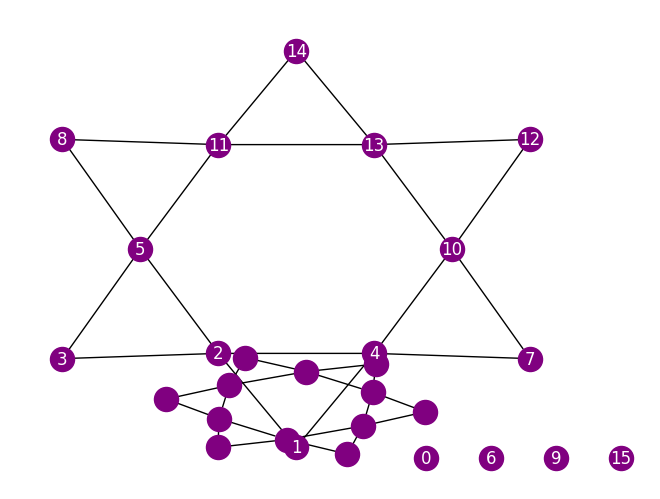

In [10]:
# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 14, t),
    (14, 13, t),
    (13, 12, t),
    (12, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 13, t),
    (13, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
kagome_unit_cell_16.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

In [11]:
# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
#ham_16

# Pulse specific settings

In [32]:
backend = provider.get_backend('ibmq_guadalupe')

# The final time of the state evolution
target_time = np.pi

# Number of trotter steps
trotter_steps = 2  ### CAN BE >= 4
t = target_time/(trotter_steps)
# Initialize quantum circuit for 3 qubits
size = 12
qr = QuantumRegister(size)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
#qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

def compute_XX_pulsegate(t_param, first, second, size):
    XX_qr = QuantumRegister(size)
    XX_qc = QuantumCircuit(XX_qr, name='XX' + str(first))
    XX_qc.ry(np.pi/2,[first,second])
    XX_qc.h(second)
    XX_qc.rzx(t_param, first, second)
    XX_qc.x(first)
    XX_qc.rzx(-t_param, first, second)
    XX_qc.x(first)
    XX_qc.h(second)
    XX_qc.ry(-np.pi/2,[first,second])
    return XX_qc

def compute_YY_pulsegate(t_param, first, second, size):
    YY_qr = QuantumRegister(size)
    YY_qc = QuantumCircuit(YY_qr, name='YY' + str(first))
    YY_qc.rx(np.pi/2,[first,second])
    YY_qc.h(second)
    YY_qc.rzx(t_param, first, second)
    YY_qc.x(first)
    YY_qc.rzx(-t_param, first, second)
    YY_qc.x(first)
    YY_qc.h(second)
    YY_qc.rx(-np.pi/2,[first,second])
    return YY_qc

def compute_ZZ_pulsegate(t_param, first, second, size):
    ZZ_qr = QuantumRegister(size)
    ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ' + str(first))
    ZZ_qc.h(second)
    ZZ_qc.rzx(t_param, first, second)
    ZZ_qc.x(first)
    ZZ_qc.rzx(-t_param, first, second)
    ZZ_qc.x(first)
    ZZ_qc.h(second)
    return ZZ_qc

target_qubits = []
for x in range(size):
    target_qubits.append(x)

p = ParameterVector('p', (size-1)*size*trotter_steps)
param_index = 0
for i in range(1,trotter_steps+1):    
        
    for j in range(size):
        # Symmetrization
        qc.h(j)
        
    for edge in original_edge_list: 
        qc.append(compute_XX_pulsegate( 1.8199999999999998 * p[param_index], edge[0], edge[1], size), target_qubits)
        param_index = param_index + 1
        qc.append(compute_YY_pulsegate( 1.8199999999999998 * p[param_index], edge[0], edge[1], size), target_qubits)
        param_index = param_index + 1
        qc.append(compute_ZZ_pulsegate( 1.8199999999999998 * p[param_index], edge[0], edge[1], size), target_qubits)
        param_index = param_index + 1
        
    # Hadamard for Symmetrization
    for j in range(size):
        # Symmetrization
        qc.h(j)

qc.decompose().draw()

┌─────────┐┌─────────┐     ┌─────────────────┐┌───┐»
 q494_0: ┤ U2(0,π) ├┤ Ry(π/2) ├─────┤0                ├┤ X ├»
         ├─────────┤├─────────┤┌───┐│  Rzx(1.82*p[0]) │└───┘»
 q494_1: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├┤1                ├─────»
         ├─────────┤├─────────┤├───┤└─────────────────┘     »
 q494_2: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├────────────────────────»
         ├─────────┤├─────────┤├───┤                        »
 q494_3: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├────────────────────────»
         ├─────────┤├─────────┤├───┤                        »
 q494_4: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├────────────────────────»
         ├─────────┤├─────────┤├───┤                        »
 q494_5: ┤ U2(0,π) ├┤ Ry(π/2) ├┤ H ├────────────────────────»
         ├─────────┤├─────────┤└───┘                        »
 q494_6: ┤ U2(0,π) ├┤ Ry(π/2) ├─────────────────────────────»
         ├─────────┤├─────────┤                             »
 q494_7: ┤ U2(0,π) ├┤ Ry(π/2) ├─────────────────────────────»
         ├─────────┤├─────────┤                             »
 q494_8: ┤ U2(0,π) ├┤ Ry(π/2) ├─────────────────────────────»
         ├─────────┤├─────────┤                             »
 q494_9: ┤ U2(0,π) ├┤ Ry(π/2) ├─────────────────────────────»
         ├─────────┤├─────────┤                             »
q494_10: ┤ U2(0,π) ├┤ Ry(π/2) ├─────────────────────────────»
         ├─────────┤├─────────┤                             »
q494_11: ┤ U2(0,π) ├┤ Ry(π/2) ├─────────────────────────────»
         └─────────┘└─────────┘                             »
«         ┌──────────────────┐┌───┐┌──────────┐┌─────────┐     »
« q494_0: ┤0                 ├┤ X ├┤ Ry(-π/2) ├┤ Rx(π/2) ├─────»
«         │  Rzx(-1.82*p[0]) │├───┤├──────────┤├─────────┤┌───┐»
« q494_1: ┤1                 ├┤ H ├┤ Ry(-π/2) ├┤ Rx(π/2) ├┤ H ├»
«         └──────────────────┘└───┘└──────────┘└─────────┘└───┘»
« q494_2: ─────────────────────────────────────────────────────»
«                                                              »
« q494_3: ─────────────────────────────────────────────────────»
«                                                              »
« q494_4: ─────────────────────────────────────────────────────»
«                                                              »
« q494_5: ─────────────────────────────────────────────────────»
«                                                              »
« q494_6: ─────────────────────────────────────────────────────»
«                                                              »
« q494_7: ─────────────────────────────────────────────────────»
«                                                              »
« q494_8: ─────────────────────────────────────────────────────»
«                                                              »
« q494_9: ─────────────────────────────────────────────────────»
«                                                              »
«q494_10: ─────────────────────────────────────────────────────»
«                                                              »
«q494_11: ─────────────────────────────────────────────────────»
«                                                              »
«         ┌─────────────────┐┌───┐┌──────────────────┐┌───┐┌──────────┐     »
« q494_0: ┤0                ├┤ X ├┤0                 ├┤ X ├┤ Rx(-π/2) ├─────»
«         │  Rzx(1.82*p[1]) │└───┘│  Rzx(-1.82*p[1]) │├───┤├──────────┤┌───┐»
« q494_1: ┤1                ├─────┤1                 ├┤ H ├┤ Rx(-π/2) ├┤ H ├»
«         └─────────────────┘     └──────────────────┘└───┘└──────────┘└───┘»
« q494_2: ──────────────────────────────────────────────────────────────────»
«                                                                           »
« q494_3: ──────────────────────────────────────────────────────────────────»
«                                                                           »
« q494_4: ──────────────────────────────────────────────────────────────────»
«                                                     

In [33]:
from qiskit import schedule
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import RZXCalibrationBuilderNoEcho

q_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
ansatz_opt = transpile(qc, backend=backend, initial_layout=q_layout)

pm = PassManager([RZXCalibrationBuilderNoEcho(backend)]) ## calibrate pulse efficient RZX
qc_pulse_noscale = pm.run(ansatz_opt)
qc_pulse_noscale = transpile(qc_pulse_noscale, backend)
#schedule(qc_pulse_noscale, backend).draw() 


In [14]:
#qc_pulse_efficient.draw()
print(len(qc_pulse_noscale.parameters))

108


In [15]:
from stretch_pulse import *  # import script for stretching pulses

scale = [2.0, 2.5, 2.8, 3.2]

stretch_scale = scale[0] 
qc_pulse_efficient = get_stretched_pulses(ansatz_opt, backend, stretch_scale)
schedule(qc_pulse_efficient, backend).draw(time_range=(0, 10000))
print(schedule(qc_pulse_efficient, backend).duration)

KeyboardInterrupt: 

In [19]:
from qiskit.algorithms.optimizers import SPSA, ADAM, SLSQP, L_BFGS_B, GradientDescent

#optimizer = SPSA(maxiter=100)
learning_rate = 0.001
iterations = 20
#optimizer = ADAM(maxiter=iterations, lr=learning_rate), 
#optimizer = SLSQP(maxiter=iterations)
#optimizer = L_BFGS_B(maxiter=100)
optimizer = GradientDescent(maxiter=iterations, learning_rate=learning_rate)

In [20]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None, init_data=False):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        self._init_data = init_data
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        if len(self._init_data) > 0:
            x0 = init_data
        else:
            x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)

        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result


In [21]:
# Define a simple callback function
intermediate_info = []
result_times = 0
def callback(value):
        global result_times
        if result_times % 50 == 0:
            print(value)
        result_times = result_times + 1    
        intermediate_info.append(value)

## 2-6 Execute simulated VQE
The VQE is built! Time to test it out on a simulator. This may take a few seconds.

In [22]:
from qiskit.primitives import Estimator

Scale: 0.8
Optimizer: SLSQP        0.2814202446423523
0.28142023465612354
0.2814202592094846
-1.4653150668495318
-1.4653150768640184
-2.8189135447113842
-2.8189135303711
-3.7105709088935757
-3.7105709184769196
-3.9624606905796904
-4.742185993956569
-4.742185997135681
-5.643665708390047
-5.643665692965247
-6.24049201172014
-6.2404920622976645
-6.838003462557729
-6.83800347583653
-1.042874642527509
-7.663331320113439
-7.663331309957755
-8.275386113546267
-8.275386106522745
-8.497805467132393
-8.497805423130481
-9.149190983960853
-9.149190970311617
-9.786637221742662
-9.786637227517298
-9.786637201086636
-10.515795095633601
-10.515795069703717
-10.998326428755666
-10.998326395408705
-11.352737779038831
-11.352737760618696
-11.895299801474573
-11.89529978035774
-11.895299798753614
-12.40970185688756
-12.40970185800834
-13.001225221060652
-13.00122522514212
-13.33900873642675
-13.339008757189132
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 2242,
    'eigenstate': None,
 

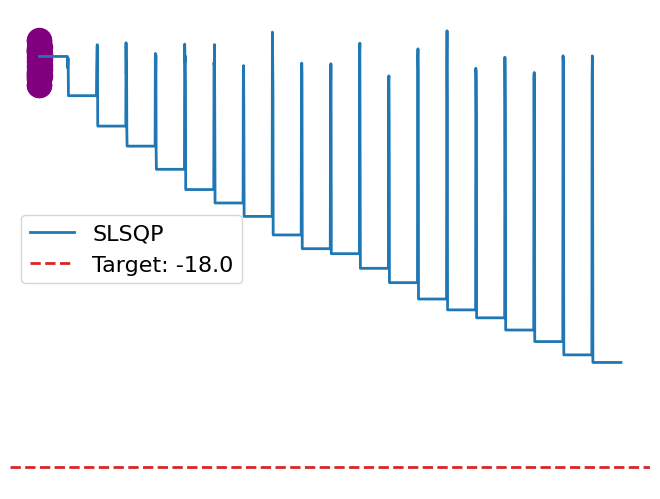

None

Scale: 2.5
Optimizer: SLSQP        0.12528648396606631
0.125286492656143
0.12528648404887943
-1.187303844648657
-1.1873038433759064
-1.7620550693777084
-1.7620550272391815
-3.2563863319008393
-3.2563863250178535
-3.773128263184312
-3.7731282745818286
-0.45783659212923766
-5.3944017904917505
-5.394401806582598
-5.9772630454007
-5.977263055000254
-7.034935464160173
-7.034935467324992
-7.924654190172193
-7.924654189701137
-1.1152851214271569
-9.046727176864419
-9.04672714556676
-9.56038441695947
-9.560384452001184
-10.290618855403357
-10.290618868093487
-10.89154401975567
-10.891544023596875
-10.891544037474937
-11.529299134686998
-11.529299107197874
-12.077357799186998
-12.077357800680867
-12.46911680693941
-12.469116824677185
-12.842737234939825
-12.842737239285379
1.0119157294411036
-13.1106269349595
-13.110626938447238
-13.4458042632448
-13.4458042837024
-13.713722628004152
-13.71372262822609
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 2243,
    'eigenstate': None

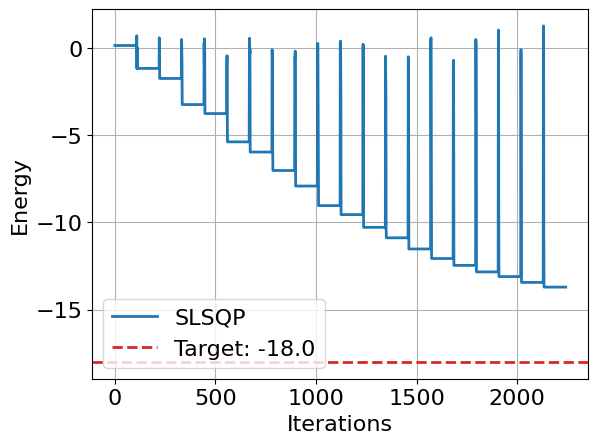

None

In [23]:
#scale = [0.8, 1.5, 2.0, 2.5, 2.8, 3.2, 4, 6]
scale = [0.8, 2.5]
learning_rate = 0.01
iterations = 20
optimizers = [
    #L_BFGS_B(maxiter=iterations), 
    SLSQP(maxiter=iterations), 
    #GradientDescent(maxiter=iterations, learning_rate=learning_rate),
]
def rel_err(target, measured):
    return abs((target - measured) / target)

#def runTests(ansatz):
        
for i, scale_value in enumerate(scale):
    print("Scale:", scale_value)
    qc_pulse_efficient = get_stretched_pulses(ansatz_opt, backend, scale_value)
    ansatz = qc_pulse_efficient
    converge_cnts = np.empty([len(optimizers)], dtype=object)

    for i, optimizer_selected in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer_selected).__name__), end='')
        #algorithm_globals.random_seed = 50

        intermediate_info = []
        counts = []
        values = []
        estimator = Estimator([ansatz], [ham_16])

        # Setup VQE algorithm
        custom_vqe = CustomVQE(estimator, ansatz, optimizer_selected, callback=callback, init_data=[])

        # Run the custom VQE function and monitor execution time
        start = time()
        result = custom_vqe.compute_minimum_eigenvalue(ham_16)
        end = time()

        print(result)
        print(f'execution time (s): {end - start:.2f}')

        rel_error = rel_err(gs_energy, result.eigenvalue)
        print("Relative error ", optimizer_selected, " ", rel_error)

        converge_cnts[i] = np.asarray(intermediate_info)

    for i, optimizer in enumerate(optimizers):
        plt.plot(converge_cnts[i], lw=2, label=type(optimizer).__name__)
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
    plt.legend()
    plt.grid()
    display(plt.show())

#print("Without Scale:")
#runTests(qc_pulse_noscale) 


Scale: 2.5
Optimizer: SLSQP        -13.71372264372463
-13.713722615869663
-14.18393974579295
-14.183939756286195
-14.183939763808562
-14.490342713841724
-14.490342705646562
-14.676574489698977
-14.676574490404029
-14.82531312954309
-14.82531313691436
-14.947949185872906
-14.94794918947053
-14.947949197694676
-15.035509973301481
-15.035509988489522
-15.110273004354962
-15.110273013964907
-15.188222985696369
-15.188222990390898
-15.232133629904155
-15.232133636562827
-15.2321336329292
-15.304618517607041
-15.304618528684633
-15.36060855850723
-15.36060855841847
-15.425579431457514
-15.425579414309464
-15.475749477853586
-15.475749473940848
-15.507579563263
-15.507579553660626
-15.507579567139448
-15.545371733371452
-15.545371726640976
-15.574153530201539
-15.574153540591405
-15.610526496775437
-15.610526516244839
-15.653304119324638
-15.653304114860203
-1.5957853676112046
-15.702628280801806
-15.702628274958476
-15.73462712037823
-15.73462712043835
-15.756543495529922
-15.75654349127369


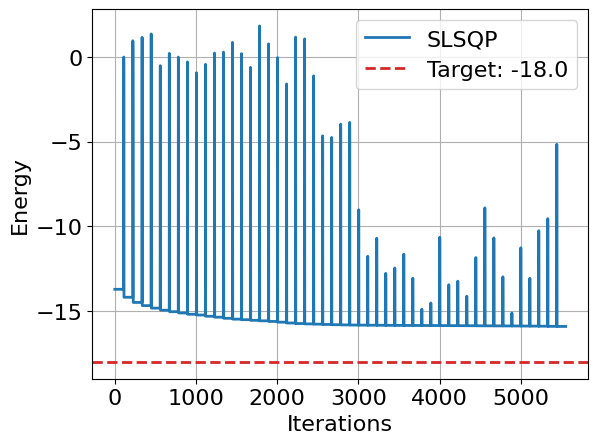

None

In [24]:
scale = [2.5]
learning_rate = 0.01
iterations = 50
optimizers = [
    #L_BFGS_B(maxiter=iterations), 
    SLSQP(maxiter=iterations), 
    #GradientDescent(maxiter=iterations, learning_rate=learning_rate),
]
def rel_err(target, measured):
    return abs((target - measured) / target)

init_data = np.array([-0.02987515,  0.87977968,  0.1095489 , -0.27062906,  0.76203151,
        0.56007633,  0.02916803,  1.0061647 ,  0.60037734,  0.04523977,
       -0.25509979,  1.11100565,  0.00999934,  0.27671511,  0.40691218,
        0.11649929,  0.41156121,  0.94793004,  0.8468862 ,  0.71170267,
        0.18646358,  0.03562752,  0.14425566,  0.81065011,  0.48564329,
        0.83941577,  0.70505203,  1.03470631,  0.3842856 ,  1.6041438 ,
        0.90457271, -0.62867995,  0.63616137, -0.02588348,  1.19266876,
       -0.44428673,  0.98456916,  0.57537907,  0.51640622,  0.54312087,
        0.53298902,  0.12303899,  0.86710826,  0.07806323,  0.41487754,
        0.29067128,  0.27886054, -0.12044515,  0.87522176,  0.27289566,
        0.17200646, -0.05958016,  0.23932927,  0.69553229,  1.23151522,
        0.05011087,  0.85971653,  0.95286314,  0.3506824 ,  0.02583244,
       -0.14651363,  0.50945606, -0.34059309,  1.10054146,  1.17990195,
        0.03987953,  0.94578906,  0.00944596, -0.12949316,  0.0334801 ,
        0.26920428,  0.75311871,  1.2381631 ,  0.02371609, -0.08996078,
       -0.45930342,  0.87900781, -0.11143114, -0.12277443,  0.87609744,
        0.86738994,  0.79203719,  0.40792842, -0.23167105,  0.04010681,
        0.60200905,  0.7552742 ,  1.02417053,  0.44136875,  1.10343963,
        0.32458104,  0.12583848,  0.1898166 ,  0.80493059,  0.19681068,
       -0.00585121,  0.71103249,  0.57332151,  0.62134457, -0.01137806,
       -0.20217042,  1.01558544,  0.22689721,  0.99153472,  1.08055573,
       -0.28051313,  0.03136412,  0.0954497 ])

for i, scale_value in enumerate(scale):
    print("Scale:", scale_value)
    qc_pulse_efficient = get_stretched_pulses(ansatz_opt, backend, scale_value)
    ansatz = qc_pulse_efficient
    converge_cnts = np.empty([len(optimizers)], dtype=object)

    for i, optimizer_selected in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer_selected).__name__), end='')
        #algorithm_globals.random_seed = 50

        intermediate_info = []
        counts = []
        values = []
        estimator = Estimator([ansatz], [ham_16])

        # Setup VQE algorithm
        custom_vqe = CustomVQE(estimator, ansatz, optimizer_selected, callback=callback, init_data=init_data)

        # Run the custom VQE function and monitor execution time
        start = time()
        result = custom_vqe.compute_minimum_eigenvalue(ham_16)
        end = time()

        print(result)
        print(f'execution time (s): {end - start:.2f}')

        rel_error = rel_err(gs_energy, result.eigenvalue)
        print("Relative error ", optimizer_selected, " ", rel_error)

        converge_cnts[i] = np.asarray(intermediate_info)

    for i, optimizer in enumerate(optimizers):
        plt.plot(converge_cnts[i], lw=2, label=type(optimizer).__name__)
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
    plt.legend()
    plt.grid()
    display(plt.show())


Scale: 2.5
Optimizer: L_BFGS_B        -15.906025533568924
-15.906025534900795
-1.8227585570812288
-1.8227585943342983
-1.822758596144783
-15.929246805012413
-15.929246803537128
-15.937597442844547
-15.937597442499946
-15.941581779796659
-15.941581780180266
-15.950690509886124
-15.950690509677598
-15.965140923719462
-15.965140926409026
-15.965140924866288
-15.987722632081685
-15.987722632884328
-16.01292630693489
-16.012926307853828
-16.042658788293863
-16.042658788420276
-16.052020421951454
-16.052020422659282
-16.066345589536237
-16.06634558925531
-16.0714787874805
-16.071478786526693
-16.071478787447568
-16.07341195296803
-16.073411953646378
-16.076066210034007
-16.07606621096565
-16.07637490982053
-16.076374909678943
-16.078522810569414
-16.078522810991164
-16.079185616516266
-16.079185616678146
-16.080136228813966
-16.080136228762072
-16.080136228838256
-16.081341850722016
-16.08134185135294
-16.08192338970796
-16.081923389857504
-16.083252697259642
-16.083252697751124
-16.08378219

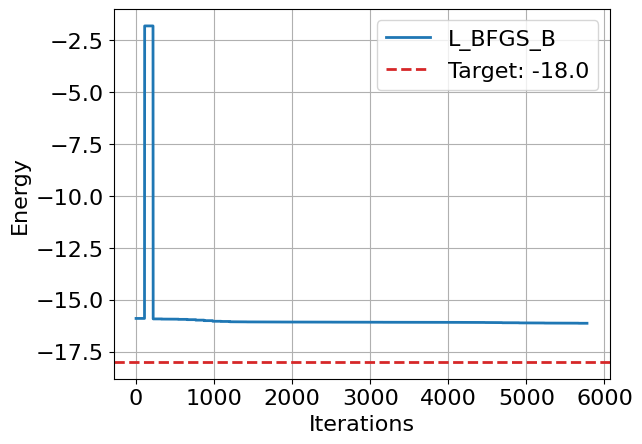

None

In [25]:
scale = [2.5]
learning_rate = 0.01
iterations = 100
optimizers = [
    L_BFGS_B(maxiter=iterations), 
    #SLSQP(maxiter=iterations), 
    #GradientDescent(maxiter=iterations, learning_rate=learning_rate),
]
def rel_err(target, measured):
    return abs((target - measured) / target)

init_data = np.array([ 2.64781923e-03,  8.60332424e-01,  5.01267543e-03, -3.78005042e-01,
        9.52242975e-01,  6.67551963e-01, -1.01282897e-02,  1.05584161e+00,
        5.29414341e-01,  1.40295996e-04, -1.56671789e-01,  1.33112469e+00,
        7.76528015e-04,  2.33093883e-01,  4.97182240e-01,  3.85018340e-03,
        3.38521788e-01,  1.02474831e+00,  9.20205263e-01,  8.85837330e-01,
        1.77916803e-01, -2.94627668e-02, -2.68306100e-02,  1.02907320e+00,
        5.90567340e-01,  8.77388270e-01,  6.54580947e-01,  1.11328177e+00,
        4.29834937e-01,  1.64865039e+00,  8.67255443e-01, -4.43661408e-01,
        8.15603748e-01,  4.82668773e-03,  1.27368507e+00, -4.10388393e-01,
        8.62710153e-01,  8.23641311e-01,  5.86922647e-01,  4.35847327e-01,
        4.82781470e-01,  1.86644241e-01,  8.65510637e-01,  2.41757955e-03,
        6.34648473e-01,  4.33974623e-01,  4.05916369e-01, -1.00470682e-01,
        8.65967555e-01,  4.24765056e-01, -1.77381427e-02,  4.13064555e-01,
       -3.09793220e-02,  6.59563877e-01,  1.72188312e+00,  2.19691956e-02,
        1.00952207e+00,  1.29004961e+00, -9.72730055e-03, -4.63128999e-03,
       -4.46926703e-01,  4.74759192e-01, -4.65798107e-01,  1.16339855e+00,
        1.31008524e+00,  2.44365371e-03,  8.66789787e-01, -5.80187367e-02,
       -1.14556654e-02,  4.37065101e-04,  7.03754596e-03,  8.91081735e-01,
        1.40083934e+00, -6.40359308e-03, -1.35573735e-01, -4.21205368e-01,
        8.66771228e-01, -5.37123250e-02, -7.32828303e-03,  8.64092913e-01,
        9.84393045e-01,  5.02087642e-01,  4.46003860e-01, -3.55808976e-01,
       -1.94420264e-03,  8.71390465e-01,  5.65799493e-01,  8.68064700e-01,
        3.94791584e-01,  1.10745346e+00,  4.32367596e-01, -1.76444490e-03,
        5.63044658e-03,  8.63901484e-01,  2.39629084e-01,  3.12591751e-02,
        9.40255777e-01,  3.66069928e-01,  8.60321808e-01, -6.32497633e-02,
       -4.71378747e-01,  1.28069880e+00,  3.05986734e-01,  8.60887851e-01,
        9.59022011e-01,  4.54991578e-03, -1.13685328e-03,  1.44263821e-02])

for i, scale_value in enumerate(scale):
    print("Scale:", scale_value)
    qc_pulse_efficient = get_stretched_pulses(ansatz_opt, backend, scale_value)
    ansatz = qc_pulse_efficient
    converge_cnts = np.empty([len(optimizers)], dtype=object)

    for i, optimizer_selected in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer_selected).__name__), end='')
        #algorithm_globals.random_seed = 50

        intermediate_info = []
        counts = []
        values = []
        estimator = Estimator([ansatz], [ham_16])

        # Setup VQE algorithm
        custom_vqe = CustomVQE(estimator, ansatz, optimizer_selected, callback=callback, init_data=init_data)

        # Run the custom VQE function and monitor execution time
        start = time()
        result = custom_vqe.compute_minimum_eigenvalue(ham_16)
        end = time()

        print(result)
        print(f'execution time (s): {end - start:.2f}')

        rel_error = rel_err(gs_energy, result.eigenvalue)
        print("Relative error ", optimizer_selected, " ", rel_error)

        converge_cnts[i] = np.asarray(intermediate_info)

    for i, optimizer in enumerate(optimizers):
        plt.plot(converge_cnts[i], lw=2, label=type(optimizer).__name__)
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
    plt.legend()
    plt.grid()
    display(plt.show())


Scale: 2.5
Optimizer: L_BFGS_B        -1.252823229612208
-1.2528232107834942
-3.73345942368302
-3.7334594204123603
-7.115809859784115
-7.1158098880745175
-8.299986913914823
-8.299986912298085
-11.444064841128816
-11.44406483483284
-12.694713251611034
-12.694713268232846
-12.694713235890292
-13.62742878359102
-13.627428777712732
-14.352741055294272
-14.352741067605852
-14.94735466374531
-14.947354657982915
-15.459552561107227
-15.459552552765949
-15.669481135465036
-15.669481136022764
-15.669481153256122
-15.827299299762783
-15.827299301127747
-15.889508614644377
-15.889508618780267
-15.941726214724326
-15.941726215288607
-15.974166429672103
-15.974166431289055
-15.995100223258586
-15.995100222212665
-16.012845764812884
-16.012845764870818
-16.01284576423836
-16.02602628557389
-16.026026283475733
-16.046931339561816
-16.04693134047577
-16.060454023106825
-16.060454029384495
-16.075445943937854
-16.075445945793007
-16.096898105414283
-16.096898107112853
-16.096898108546235
-16.1249038343

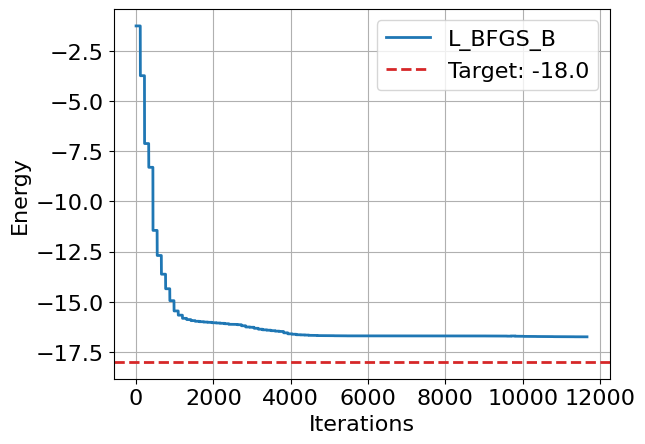

None

In [31]:
scale = [2.5]
learning_rate = 0.01
iterations = 100
optimizers = [
    L_BFGS_B(maxiter=iterations), 
    #SLSQP(maxiter=iterations), 
    #GradientDescent(maxiter=iterations, learning_rate=learning_rate),
]
def rel_err(target, measured):
    return abs((target - measured) / target)

init_data = np.array([ 2.64781923e-03,  8.60332424e-01,  5.01267543e-03, -3.78005042e-01,
        9.52242975e-01,  6.67551963e-01, -1.01282897e-02,  1.05584161e+00,
        5.29414341e-01,  1.40295996e-04, -1.56671789e-01,  1.33112469e+00,
        7.76528015e-04,  2.33093883e-01,  4.97182240e-01,  3.85018340e-03,
        3.38521788e-01,  1.02474831e+00,  9.20205263e-01,  8.85837330e-01,
        1.77916803e-01, -2.94627668e-02, -2.68306100e-02,  1.02907320e+00,
        5.90567340e-01,  8.77388270e-01,  6.54580947e-01,  1.11328177e+00,
        4.29834937e-01,  1.64865039e+00,  8.67255443e-01, -4.43661408e-01,
        8.15603748e-01,  4.82668773e-03,  1.27368507e+00, -4.10388393e-01,
        8.62710153e-01,  8.23641311e-01,  5.86922647e-01,  4.35847327e-01,
        4.82781470e-01,  1.86644241e-01,  8.65510637e-01,  2.41757955e-03,
        6.34648473e-01,  4.33974623e-01,  4.05916369e-01, -1.00470682e-01,
        8.65967555e-01,  4.24765056e-01, -1.77381427e-02,  4.13064555e-01,
       -3.09793220e-02,  6.59563877e-01,  1.72188312e+00,  2.19691956e-02,
        1.00952207e+00,  1.29004961e+00, -9.72730055e-03, -4.63128999e-03,
       -4.46926703e-01,  4.74759192e-01, -4.65798107e-01,  1.16339855e+00,
        1.31008524e+00,  2.44365371e-03,  8.66789787e-01, -5.80187367e-02,
       -1.14556654e-02,  4.37065101e-04,  7.03754596e-03,  8.91081735e-01,
        1.40083934e+00, -6.40359308e-03, -1.35573735e-01, -4.21205368e-01,
        8.66771228e-01, -5.37123250e-02, -7.32828303e-03,  8.64092913e-01,
        9.84393045e-01,  5.02087642e-01,  4.46003860e-01, -3.55808976e-01,
       -1.94420264e-03,  8.71390465e-01,  5.65799493e-01,  8.68064700e-01,
        3.94791584e-01,  1.10745346e+00,  4.32367596e-01, -1.76444490e-03,
        5.63044658e-03,  8.63901484e-01,  2.39629084e-01,  3.12591751e-02,
        9.40255777e-01,  3.66069928e-01,  8.60321808e-01, -6.32497633e-02,
       -4.71378747e-01,  1.28069880e+00,  3.05986734e-01,  8.60887851e-01,
        9.59022011e-01,  4.54991578e-03, -1.13685328e-03,  1.44263821e-02])

for i, scale_value in enumerate(scale):
    print("Scale:", scale_value)
    qc_pulse_efficient = get_stretched_pulses(ansatz_opt, backend, scale_value)
    ansatz = qc_pulse_efficient
    converge_cnts = np.empty([len(optimizers)], dtype=object)

    for i, optimizer_selected in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer_selected).__name__), end='')
        #algorithm_globals.random_seed = 50

        intermediate_info = []
        counts = []
        values = []
        estimator = Estimator([ansatz], [ham_16])

        # Setup VQE algorithm
        custom_vqe = CustomVQE(estimator, ansatz, optimizer_selected, callback=callback, init_data=init_data)

        # Run the custom VQE function and monitor execution time
        start = time()
        result = custom_vqe.compute_minimum_eigenvalue(ham_16)
        end = time()

        print(result)
        print(f'execution time (s): {end - start:.2f}')

        rel_error = rel_err(gs_energy, result.eigenvalue)
        print("Relative error ", optimizer_selected, " ", rel_error)

        converge_cnts[i] = np.asarray(intermediate_info)

    for i, optimizer in enumerate(optimizers):
        plt.plot(converge_cnts[i], lw=2, label=type(optimizer).__name__)
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
    plt.legend()
    plt.grid()
    display(plt.show())


Scale: 3.5
Optimizer: L_BFGS_B        0.383323886908426
0.38332384890383053
-3.6449618968539075
-3.644961904868835
-7.498219667683219
-7.498219656164812
-10.20573556981686
-10.205735582498463
-10.205735584653704
-11.642783081166288
-11.64278309712548
-12.382121989798417
-12.382121996332206
-13.015098857669022
-13.015098847605941
-13.88453007408946
-13.88453008680887
-14.28177274891472
-14.281772753213918
-14.546635017729557
-14.546635020951049
-14.546635010937102
-14.705535867759254
-14.705535866528683
-14.797422832915668
-14.79742282997945
-14.962296322340576
-14.962296322593952
-15.099844640477299
-15.09984463910251
-15.33533016875173
-15.335330162957252
-15.335330158777516
-15.599870576328156
-15.599870593265697
-15.805406655860137
-15.805406661837248
-16.05345152315088
-16.053451536881283
-16.43273424081985
-16.43273424035152
-16.629838345404714
-16.62983834490262
-16.76924144177267
-16.769241442910406
-16.769241433807196
{   'aux_operator_eigenvalues': None,
    'cost_function_eva

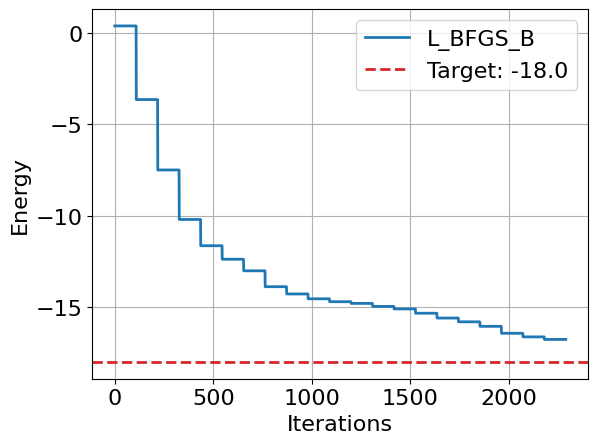

None

In [34]:
scale = [3.5]
learning_rate = 0.01
iterations = 20
optimizers = [
    L_BFGS_B(maxiter=iterations), 
    #SLSQP(maxiter=iterations), 
    #GradientDescent(maxiter=iterations, learning_rate=learning_rate),
]
def rel_err(target, measured):
    return abs((target - measured) / target)

init_data = np.array([-1.93640708e-01,  8.77843220e-01, -5.87942922e-03,  7.21338714e-03,
        1.00129469e+00,  9.27394553e-01, -1.01335731e-03,  1.25919015e+00,
        3.83016098e-01, -1.50925382e-04, -1.06324487e-01,  1.32526321e+00,
        2.76609194e-03,  2.26807668e-01,  4.40356195e-01,  2.43814260e-03,
        5.07045660e-01,  1.03614493e+00,  8.68302845e-01,  8.77187010e-01,
        3.98385058e-01, -6.25193614e-02, -2.14299569e-02,  9.13765360e-01,
        8.30550734e-01,  8.84800443e-01,  7.76260851e-01,  9.26233087e-01,
        2.38872239e-01,  1.86033630e+00,  6.35749098e-01, -8.61349185e-01,
        8.68278172e-01, -4.33523926e-01,  1.22000554e+00, -3.20202481e-01,
        3.97013187e-01,  8.63298169e-01,  8.63727534e-01,  4.30371388e-01,
        4.24974398e-01,  2.03370677e-01,  7.96763809e-01, -3.12863439e-03,
        8.63741935e-01,  4.31087154e-01,  4.73275973e-01,  3.84610882e-02,
        8.63712979e-01,  1.01289061e+00, -4.47933404e-02,  3.86788333e-01,
        5.08822363e-04,  8.58997909e-01,  1.42762756e+00, -2.62838178e-03,
        8.64926531e-01,  1.22009559e+00,  7.54462934e-02, -5.22254676e-02,
       -3.66583654e-01,  5.62763274e-01, -3.14979029e-01,  8.97725639e-01,
        1.40882111e+00,  1.69636651e-01,  1.27475965e+00, -3.67630901e-01,
       -1.33301080e-01, -1.80829726e-04, -7.74279819e-02,  1.28613892e+00,
        1.34658466e+00,  3.16411858e-01, -2.44661020e-01, -4.97629489e-01,
        8.66828448e-01,  8.66416521e-02, -2.69025676e-01,  7.39419609e-01,
        9.73158964e-01,  8.64756195e-01,  5.68211072e-01, -3.26855297e-01,
        1.17603609e-05,  6.32617783e-01,  4.30512045e-01,  8.63986815e-01,
        5.07830199e-01,  9.51975245e-01,  2.18061856e-01, -2.66024537e-02,
       -2.12124578e-01,  8.59286062e-01,  1.79001951e-03, -3.42063506e-04,
        8.71274060e-01,  3.89806474e-01,  5.33303571e-01, -1.23105463e-01,
       -4.36328181e-01,  1.30547288e+00,  6.26579450e-01,  4.29653123e-01,
        8.88418646e-01,  7.85784423e-02,  1.18363556e-03,  7.24446652e-02])

for i, scale_value in enumerate(scale):
    print("Scale:", scale_value)
    qc_pulse_efficient = get_stretched_pulses(ansatz_opt, backend, scale_value)
    ansatz = qc_pulse_efficient
    converge_cnts = np.empty([len(optimizers)], dtype=object)

    for i, optimizer_selected in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer_selected).__name__), end='')
        #algorithm_globals.random_seed = 50

        intermediate_info = []
        counts = []
        values = []
        estimator = Estimator([ansatz], [ham_16])

        # Setup VQE algorithm
        custom_vqe = CustomVQE(estimator, ansatz, optimizer_selected, callback=callback, init_data=init_data)

        # Run the custom VQE function and monitor execution time
        start = time()
        result = custom_vqe.compute_minimum_eigenvalue(ham_16)
        end = time()

        print(result)
        print(f'execution time (s): {end - start:.2f}')

        rel_error = rel_err(gs_energy, result.eigenvalue)
        print("Relative error ", optimizer_selected, " ", rel_error)

        converge_cnts[i] = np.asarray(intermediate_info)

    for i, optimizer in enumerate(optimizers):
        plt.plot(converge_cnts[i], lw=2, label=type(optimizer).__name__)
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
    plt.legend()
    plt.grid()
    display(plt.show())


Scale: 3.5
Optimizer: L_BFGS_B        -16.76924144892466
-16.769241449572547
-2.4073621961342324
-2.407362203521419
-16.82584926558189
-16.82584926413589
-16.86082234489752
-16.86082234446449
-16.923809112662745
-16.92380911370562
-16.923809116366407
-16.959892623814163
-16.959892621385418
-16.968798483813032
-16.96879848366014
-17.001116573762044
-17.00111657304437
-17.00553662715454
-17.005536627254237
-17.015565227422623
-17.015565227740538
-17.031892486810477
-17.03189248574434
-17.031892485105864
-17.031975343940058
-17.03197534607575
-17.038952195773675
-17.038952196005127
-17.045274910668535
-17.045274910665693
-17.048187891600598
-17.04818789099041
-17.049330159449287
-17.049330159243507
-17.049330159708607
-17.05034557750815
-17.05034557795933
-17.052531175058203
-17.052531175111497
-17.052967095990947
-17.05296709650797
-17.054160602246046
-17.054160602609677
-17.05479651611156
-17.054796515829036
-17.05578606787746
-17.05578606842615
-17.05578606741919
-17.057162659015706
-1

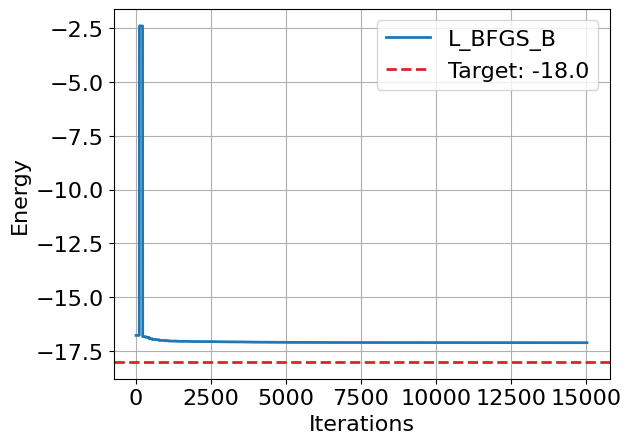

None

In [35]:
scale = [3.5]
learning_rate = 0.01
iterations = 200
optimizers = [
    L_BFGS_B(maxiter=iterations), 
    #SLSQP(maxiter=iterations), 
    #GradientDescent(maxiter=iterations, learning_rate=learning_rate),
]
def rel_err(target, measured):
    return abs((target - measured) / target)

init_data = np.array([-0.19364099,  0.86752529,  0.00443745,  0.01216531,  0.8852764 ,
        0.83408471,  0.16933402,  1.34681097,  0.48530212, -0.01287949,
        0.07354057,  1.65232719,  0.11396519,  0.36831234,  0.36763178,
       -0.03182113,  0.46017749,  1.25333748,  0.89855149,  0.72967022,
        0.19225687,  0.10019789,  0.02267654,  0.84704487,  0.97494013,
        0.82683501,  0.83627362,  1.13034155,  0.00360999,  1.71895626,
        0.73846909, -0.91497502,  0.92795236, -0.47205509,  1.52562121,
       -0.20202322,  0.42727411,  0.85987204,  0.86488935,  0.42750681,
        0.32149775,  0.32649105,  0.71556955, -0.06925784,  0.81242898,
        0.39021614,  0.51016391,  0.20685937,  0.7265903 ,  0.91550199,
       -0.04752254,  0.38442326, -0.08481917,  0.7055262 ,  1.62831531,
        0.0229908 ,  0.85078973,  1.19051136, -0.01117173, -0.02136642,
       -0.37207897,  0.43824979, -0.41973648,  1.04731102,  1.46728613,
        0.26072944,  1.10150551, -0.53348757, -0.32541849,  0.00409559,
       -0.07992798,  1.5587826 ,  1.21289414, -0.0033058 , -0.01933481,
       -0.69649273,  0.64842977, -0.24167102, -0.43077619,  0.88896838,
        0.85795056,  1.04163275,  0.40032624, -0.40390227,  0.23465851,
        0.39956749,  0.4603516 ,  1.00222481,  0.1935651 ,  1.09409005,
        0.43205429, -0.00773632, -0.00539978,  0.56065974, -0.18594507,
        0.2256604 ,  1.31423831,  0.09519226,  0.74296314, -0.11693679,
       -0.72287588,  1.54674838,  0.70082888,  0.1466017 ,  0.95095116,
       -0.00383186, -0.11954398,  0.0526628 ])

for i, scale_value in enumerate(scale):
    print("Scale:", scale_value)
    qc_pulse_efficient = get_stretched_pulses(ansatz_opt, backend, scale_value)
    ansatz = qc_pulse_efficient
    converge_cnts = np.empty([len(optimizers)], dtype=object)

    for i, optimizer_selected in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer_selected).__name__), end='')
        #algorithm_globals.random_seed = 50

        intermediate_info = []
        counts = []
        values = []
        estimator = Estimator([ansatz], [ham_16])

        # Setup VQE algorithm
        custom_vqe = CustomVQE(estimator, ansatz, optimizer_selected, callback=callback, init_data=init_data)

        # Run the custom VQE function and monitor execution time
        start = time()
        result = custom_vqe.compute_minimum_eigenvalue(ham_16)
        end = time()

        print(result)
        print(f'execution time (s): {end - start:.2f}')

        rel_error = rel_err(gs_energy, result.eigenvalue)
        print("Relative error ", optimizer_selected, " ", rel_error)

        converge_cnts[i] = np.asarray(intermediate_info)

    for i, optimizer in enumerate(optimizers):
        plt.plot(converge_cnts[i], lw=2, label=type(optimizer).__name__)
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
    plt.legend()
    plt.grid()
    display(plt.show())


## 3-1 Qiskit runtime (cloud simulator)

Next we demonstrate how to run VQE using [qiskit_ibm_runtime](https://github.com/Qiskit/qiskit-ibm-runtime) **which has different syntax from qiskit terra's runtime**. The qiskit_ibm_runtime module includes the same programming model as qiskit terra, but qiskit_ibm_runtime has access to a cloud simulator and more importantly the ibmq_guadalupe device. To learn more about qiskit_ibm_runtime check out these tutorials from the docs: [a tutorial on the estimator](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/tutorials/how-to-getting-started-with-estimator.ipynb) and [a tutorial on the sampler](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/tutorials/how-to-getting-started-with-sampler.ipynb).

We will use all the same VQE components we've built up so far, but the syntax for executing on the hardware is wrapped in [a session](https://quantum-computing.ibm.com/lab/docs/iql/manage/systems/sessions/) as shown in the following cells.

We first demonstrate running VQE with the cloud simulator backend to check everything is working correctly. This may take a few minutes. After running on the cloud simulator, we make a simple switch of backends to the real ibmq_guadalupe device to get the final result. Depending on how your VQE is setup, this may take a couple hours.

In [41]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session, Options,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="", overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')

In [42]:
# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
#backend = service.get_backend('ibmq_qasm_simulator') # ibmq_qasm_simulator simulator_statevector
backend = noisy_sim

Simulators: [<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>]


In [43]:
# Define a simple callback function
intermediate_info_sim_backend = []
result_times = 0
def callback_sim(value):
        global result_times
        if result_times % 50 == 0:
            print(result_times, ":", value)
            #print(dir(value))
        result_times = result_times + 1   
        intermediate_info_sim_backend.append(value)

In [44]:
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

scale = [2.5]

learning_rate = 0.01
iterations = 4
optimizers = [
    L_BFGS_B(maxiter=iterations), 
    SLSQP(maxiter=iterations), 
    GradientDescent(maxiter=iterations, learning_rate=learning_rate),
]
def rel_err(target, measured):
    return abs((target - measured) / target)

noise_model = NoiseModel.from_backend(backend)

options = Options()
options.execution.shots = 10
options.optimization_level = 2
options.resilience_level = 1
#options.max_execution_time = None
options.simulator.noise_model = noise_model
# GlobalFoldingAmplifer LocalFoldingAmplifer CxAmplifer
# LinearExtrapolator PolynomialExtrapolator QuadraticExtrapolator

options.resilience.noise_factors = (1,2,3,4,5,6,7,8)
options.resilience.noise_amplifer = 'LocalFoldingAmplifer'
#options.resilience.noise_amplifer.gates_to_fold = 2
#options.resilience.noise_amplifer.sub_folding_option = 'from_first'
options.resilience.extrapolator = 'PolynomialExtrapolator'
#options.resilience.extrapolator.degree = 2

#options.resilience.noise_factors = (1,2,3,4,5,6,7,8)
#options.resilience.noise_amplifer = 'LocalFoldingAmplifer'
#options.resilience.extrapolator = 'QuadraticExtrapolator'

for i, scale_value in enumerate(scale):
    print("Scale:", scale_value)
    qc_pulse_efficient = get_stretched_pulses(ansatz_opt, backend, scale_value)
    ansatz = qc_pulse_efficient
    converge_cnts = np.empty([len(optimizers)], dtype=object)

    for i, optimizer_selected in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer_selected).__name__), end='')

        intermediate_info_sim_backend = []
        counts = []
        values = []
        estimator = Estimator([ansatz], [ham_16])

        start = time()
        with Session(service=service, backend=backend) as session:
            # Prepare primitive
            rt_estimator = RuntimeEstimator(session=session, options=options)
            # Set up algorithm
            custom_vqe = CustomVQE(rt_estimator, ansatz, optimizer_selected, callback=callback_sim, init_data=[])
            # Run the custom VQE function and monitor execution time
            result = custom_vqe.compute_minimum_eigenvalue(ham_16)
        end = time()

        print(result)
        print(f'execution time (s): {end - start:.2f}')

        rel_error = rel_err(gs_energy, result.eigenvalue)
        print("Relative error ", optimizer_selected, " ", rel_error)

        converge_cnts[i] = np.asarray(intermediate_info)

    for i, optimizer in enumerate(optimizers):
        plt.plot(converge_cnts[i], lw=2, label=type(optimizer).__name__)
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
    plt.legend()
    plt.grid()
    display(plt.show())


Scale: 2.5
Optimizer: L_BFGS_B        

QiskitBackendNotFoundError: 'Backend fake_guadalupe cannot be found in any hub/group/project for this account.'

In [ ]:
print(result)

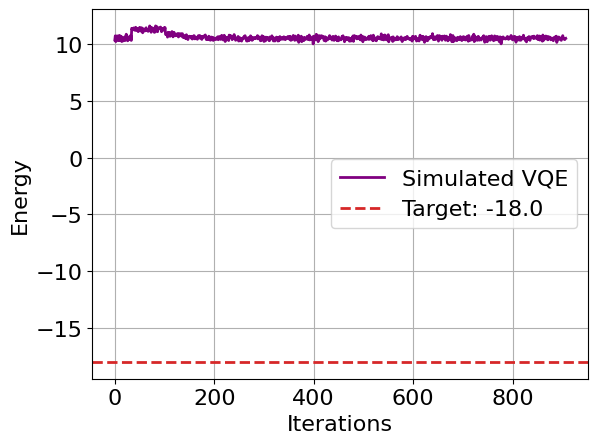

In [32]:
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [33]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the measured
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -1.6472500000
Relative error: 0.90848611


# Qiskit Fake backend

In [52]:
from qiskit.primitives import BackendEstimator
# Define fake backend
noisy_backend = noisy_sim

# Define a simple callback function
intermediate_info_real_backend = []
def callback_real(value):
        intermediate_info_real_backend.append(value)

scale = [0.8, 2, 2.5, 3]

learning_rate = 0.01
iterations = 30
optimizers = [
    #L_BFGS_B(maxiter=iterations), 
    SLSQP(maxiter=iterations), 
    GradientDescent(maxiter=iterations, learning_rate=learning_rate),
]
def rel_err(target, measured):
    return abs((target - measured) / target)

for i, scale_value in enumerate(scale):
    print("Scale:", scale_value)
    qc_pulse_efficient = get_stretched_pulses(ansatz_opt, backend, scale_value)
    ansatz = qc_pulse_efficient
    converge_cnts = np.empty([len(optimizers)], dtype=object)

    for i, optimizer_selected in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer_selected).__name__), end='')
        #algorithm_globals.random_seed = 50

        intermediate_info_real_backend = []
        counts = []
        values = []
        estimator = Estimator([ansatz], [ham_16])

        # Setup VQE algorithm
        custom_vqe = CustomVQE(noisy_estimator, ansatz, optimizer_selected, callback=callback_real, init_data=[])

        # Run the custom VQE function and monitor execution time
        start = time()
        result = custom_vqe.compute_minimum_eigenvalue(ham_16)
        end = time()

        print(result)
        print(f'execution time (s): {end - start:.2f}')

        rel_error = rel_err(gs_energy, result.eigenvalue)
        print("Relative error ", optimizer_selected, " ", rel_error)

        converge_cnts[i] = np.asarray(intermediate_info_real_backend)

    for i, optimizer in enumerate(optimizers):
        plt.plot(converge_cnts[i], lw=2, label=type(optimizer).__name__)
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
    plt.legend()
    plt.grid()
    display(plt.show())


Scale: 0.8
Optimizer: SLSQP        

KeyboardInterrupt: 

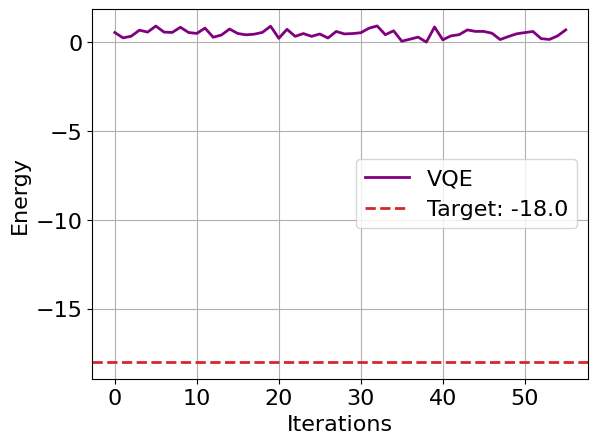

In [48]:
plt.plot(intermediate_info_real_backend, color='purple', lw=2, label='VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [49]:
# Compute the relative error between the expected ground state energy and the measured
computed_gse = intermediate_info_real_backend[-1]

print(f'Expected ground state energy: {gs_energy:.8f}')
print(f'Computed ground state energy: {computed_gse:.8f}')
print(f'Relative error: {100 * rel_err(gs_energy, computed_gse):.8f} %')

Expected ground state energy: -18.00000000
Computed ground state energy: 0.66796875
Relative error: 103.71093750 %


## 3-2 Qiskit runtime Real backend (ibmq_guadalupe)

If our `qiskit_ibm_runtime` code is working on the cloud simulator backend, we can simply change the backend to the ibmq_guadalupe to run on the real backend. This may take a couple hours. Your performance score will be determined by the calculated relative error between the true ground state energy of -18.0 and the measured energy from the real ibmq_guadalupe backend.

In [ ]:
service = QiskitRuntimeService(channel='ibm_quantum')

backend = service.get_backend('ibmq_guadalupe')
#backend = noisy_sim

options = Options()
options.execution.shots = 4000
options.optimization_level = 2
options.resilience_level = 2
options.max_execution_time = None
options.resilience.noise_factors = (2,3)
options.resilience.noise_amplifer = 'CxAmplifer'
options.resilience.extrapolator = 'QuadraticExtrapolator'

optimizer = L_BFGS_B(maxiter=100)

In [ ]:
# Define a simple callback function
intermediate_info_real_backend = []
result_times = 0
def callback_real(value):
        global result_times
        if result_times % 50 == 0:
            print(value)
        result_times = result_times + 1   
        intermediate_info_real_backend.append(value)

In [ ]:
# Setup Estimator
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session, options=options)
    # set up algorithm
    custom_vqe = CustomVQE(rt_estimator, qc_pulse_efficient, optimizer, callback=callback_real, init_data=None)
    # run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()
print(f'execution time (s): {end - start:.2f}')

In [ ]:
#job = backend.retrieve_job('cf0kerkq7eg6m2pp3cd0')
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

In [ ]:
plt.plot(intermediate_info_real_backend, color='purple', lw=2, label='VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

## 3-3 Performance Score
Compute the relative error between the expected ground state energy and the VQE result.

In [ ]:
# Compute the relative error between the expected ground state energy and the measured
computed_gse = intermediate_info_real_backend[-1]

print(f'Expected ground state energy: {gs_energy:.8f}')
print(f'Computed ground state energy: {computed_gse:.8f}')
print(f'Relative error: {100 * rel_err(gs_energy, computed_gse):.8f} %')

# Considerations
Feeling stuck? Below are a list of questions and considerations to help spark new ideas for your VQE implementation.

**Ansatz.** Carefully consult research literature for the best approach of ansatz selection. How might errors affect your ansatz? How many parameters are needed to reach the ground state? What properties of the Hamiltonian could help simplify the ansatz?

**Classical optimizer.** What optimizer will pair well with for your choice of ansatz and measurement parameters? What noise do you expect from the quantum computer, and what noise sensitivity can the classical optimizer withstand? How many iterations will be needed?

**Initial state/point.** Is there an initial quantum state that really helps things get going? What about a starting point for the circuit parameters? Does the VQE give the same results for different initial parameter values?

**Number of measurements.** How does the number of shots affect the VQE's convergence to the ground state energy? The expectation value of the Hamiltonian is a sum of the expectation values of each of the 54 terms. What is the least number of circuit executions necessary to compute the expectation value of the Hamiltonian? What is the optimal number of circuit executions for stable convergence?

**Many qubits.** Working with larger numbers of qubits is its own challenge. For example, what's a concise way of writing down or even visualizing the 4096 digit ground state? What methods and techniques will not scale well? What techniques would scale well if this VQE were to be done on a larger system? How can you reduce your execution time of the real device?

**Error mitigation.** What errors are most prevalent, and how can you reduce them efficiently? What error mitigation techniques will scale well?

In [ ]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table